In [27]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os

def load_data_from_folders(base_dir, activity_folders):
    column_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data = pd.DataFrame()
    label_encoder = LabelEncoder()
    scaler = StandardScaler()
    
    # Load data from each folder
    for activity in activity_folders:
        folder_path = os.path.join(base_dir, activity)
        files = [f for f in os.listdir(folder_path) if not os.path.isdir(os.path.join(folder_path, f))]
        activity_data = pd.DataFrame()
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            try:
                # Ensure data does not include any non-numeric values or unexpected strings
                temp_df = pd.read_csv(file_path, comment='#', header=None, names=column_names, on_bad_lines='skip')
                temp_df = temp_df.dropna()  # Drop any rows with NaN values
                temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
                temp_df['label'] = activity
                activity_data = pd.concat([activity_data, temp_df], ignore_index=True)
            except pd.errors.ParserError as e:
                print(f"Skipping file {file} due to errors: {e}")
        
        all_data = pd.concat([all_data, activity_data], ignore_index=True)

    # Encode labels
    all_data['label'] = label_encoder.fit_transform(all_data['label'])
    
    # Check for non-numeric values
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data[feature_columns] = all_data[feature_columns].apply(pd.to_numeric, errors='coerce')  # Coerce any remaining non-numeric entries to NaN, and then drop them
    all_data = all_data.dropna(subset=feature_columns)
    
    # Normalize features
    all_data[feature_columns] = scaler.fit_transform(all_data[feature_columns])
    
    return all_data, label_encoder.classes_

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    for i in range(len(data) - seq_length):
        seq = data[feature_columns].iloc[i:i + seq_length].values
        label = data['label'].iloc[i + seq_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

def augment_data(samples, target_length):
    augmented_samples = []
    for sample in samples:
        augmented_sample = sample.copy()  # Make a copy to avoid modifying the original data
        augmented_sample = time_shift(augmented_sample, max_shift=5)  # Example: Maximum shift of 5 time steps
        augmented_sample = add_noise(augmented_sample, noise_level=0.1)  # Example: Add Gaussian noise with standard deviation 0.1
        
        # Pad or crop the sample to the target length
        if augmented_sample.shape[0] < target_length:
            pad_width = ((0, target_length - augmented_sample.shape[0]), (0, 0))
            augmented_sample = np.pad(augmented_sample, pad_width, mode='constant', constant_values=0)
        elif augmented_sample.shape[0] > target_length:
            augmented_sample = augmented_sample[:target_length]
        
        augmented_samples.append(augmented_sample)
    
    return np.array(augmented_samples)

# Parameters
base_dir = '/Users/habib/Desktop/University/Spring-2024/CS73389H/Project/activity+recognition+system+based+on+multisensor+data+fusion+arem'
activity_folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
seq_length = 50
target_length = 50  # Length to which augmented samples will be padded or cropped

# Load and preprocess data
data, classes = load_data_from_folders(base_dir, activity_folders)

# Generate sequences
sequences, labels = create_sequences(data, seq_length)

# Split data into train, val, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 20% of the entire dataset for validation

# Augment training data
X_train_augmented = augment_data(X_train, target_length=target_length)
X_train = np.concatenate([X_train, X_train_augmented], axis=0)
y_train = np.concatenate([y_train, y_train], axis=0)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)


/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_14918/2959485972.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_14918/2959485972.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_14918/2959485972.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_14918/2959485972.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use 

In [30]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([50046, 50, 6])
torch.Size([8342, 50, 6])
torch.Size([8342, 50, 6])


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

In [32]:
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.5):
        super(EnhancedLSTMModel, self).__init__()
        
        # Define the number of layers and nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim*2, 128)  # Multiply by 2 for bidirectional LSTM
        self.fc2 = nn.Linear(128, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        
        # LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Fully connected layers
        out = self.dropout(F.relu(self.fc1(out[:, -1, :])))  # Take only the last time step
        out = self.fc2(out)
        return out


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        
        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM Network
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initializing hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initializing cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Indexing hidden state of the last time step
        out = self.fc(out[:, -1, :]) 
        return out


In [35]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

def validate_model(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    val_loss = criterion(outputs, labels)
    accuracy = 100 * correct / total
    return val_loss, accuracy, all_labels, all_predicted


In [36]:
# Model parameters
input_dim = 6  # Number of features
hidden_dim = 100  # Number of hidden nodes
layer_dim = 1  # Number of LSTM layers
output_dim = len(classes)  # Number of outputs
learning_rate = 0.001

# Initialize model, loss, and optimizer
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, all_labels, all_predicted = validate_model(model, val_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Accuracy: {val_accuracy}%')

# After training
conf_matrix = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(conf_matrix)


/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5, Training Loss: 0.6047016532943986, Validation Loss: 0.6967447400093079, Accuracy: 86.23831215535843%
Epoch 2/5, Training Loss: 0.38622337690247294, Validation Loss: 0.3918600380420685, Accuracy: 89.99040997362742%
Epoch 3/5, Training Loss: 0.3474562878975326, Validation Loss: 0.3265385925769806, Accuracy: 91.48885159434188%
Epoch 4/5, Training Loss: 0.2811095654068853, Validation Loss: 0.18750233948230743, Accuracy: 93.65859506113642%
Epoch 5/5, Training Loss: 0.2521219792611459, Validation Loss: 0.18299731612205505, Accuracy: 93.8743706545193%
Confusion Matrix:
[[ 656    1    0    0   36    0    0]
 [  13  361    0    0   91    0    0]
 [   0    1 1456    0    0    0    0]
 [   0    0    2 1392   27   14    0]
 [  31    0    0    7 1252  120    0]
 [   0    0    0    3  161 1307    1]
 [   0    0    3    0    0    0 1407]]


In [37]:
test_loss, test_accuracy, test_labels, test_predictions = validate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%')

Test Loss: 0.10070092976093292, Test Accuracy: 94.29393430831935%


In [38]:
%pip install tsai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 34.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.2 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━

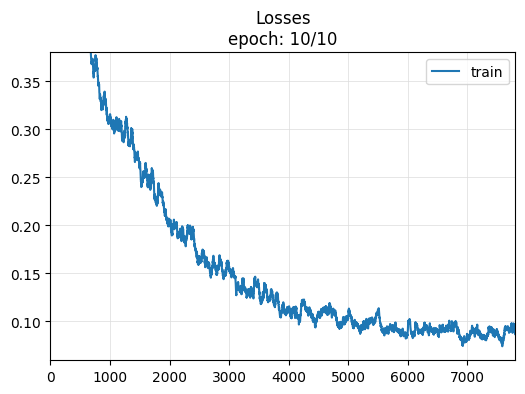

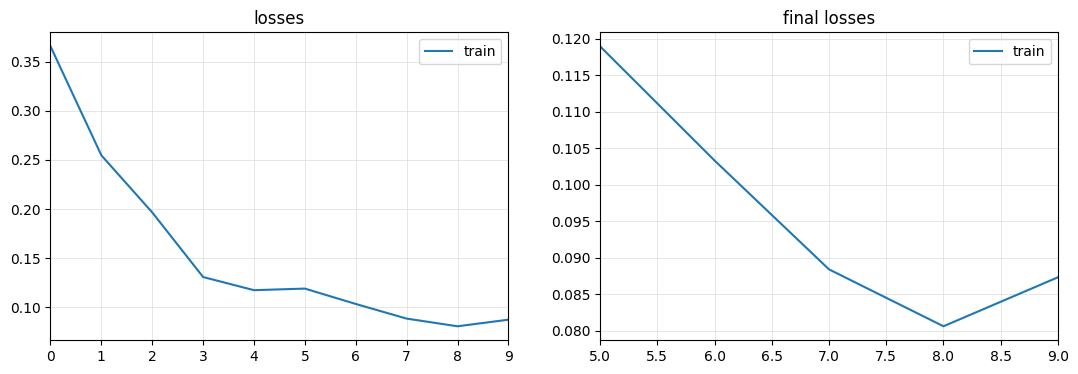

In [41]:
from tsai.basics import *


tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X_train, y_train, path='models', arch="InceptionTimePlus", tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
mv_clf.fit_one_cycle(10, 1e-3)
mv_clf.export("mv_clf.pkl")

In [43]:
from tsai.inference import load_learner

mv_clf = load_learner("models/mv_clf.pkl")
probas, target, preds = mv_clf.get_X_preds(X_test, y_test)

In [46]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_predictions, target_names=classes))


              precision    recall  f1-score   support

    bending1       0.96      0.96      0.96       704
    bending2       0.99      0.81      0.89       483
     cycling       1.00      1.00      1.00      1467
       lying       0.99      0.97      0.98      1381
     sitting       0.82      0.90      0.86      1478
    standing       0.90      0.89      0.90      1401
     walking       1.00      1.00      1.00      1428

    accuracy                           0.94      8342
   macro avg       0.95      0.93      0.94      8342
weighted avg       0.95      0.94      0.94      8342



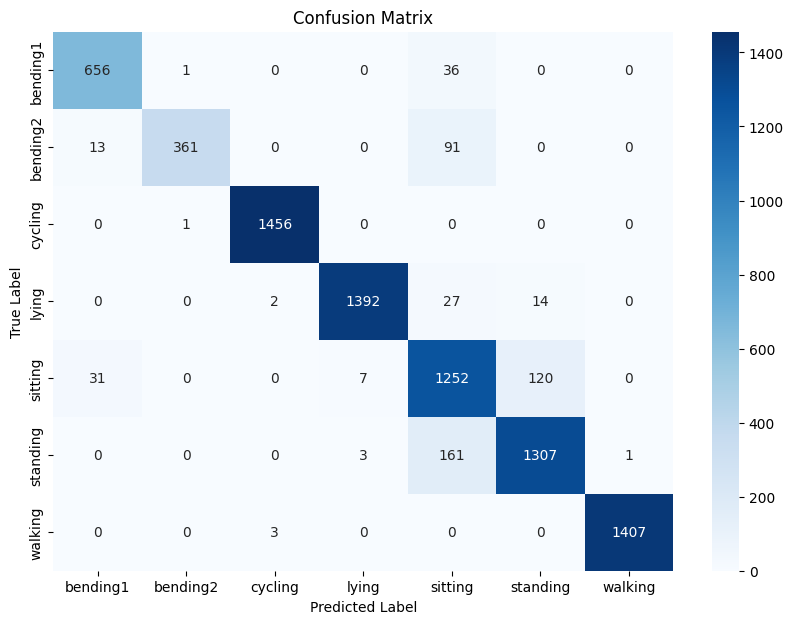

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming 'classes' variable holds class names from LabelEncoder
plot_confusion_matrix(conf_matrix, classes)
